In [39]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np


In [40]:
desired_width = 100
desired_height = 100

transform = transforms.Compose([
    transforms.Resize((desired_width, desired_height)),  # Замените desired_width и desired_height на желаемые значения
    transforms.ToTensor(),
])

train_set = torchvision.datasets.ImageFolder(root= r'D:\Brownian motion noise dataset', transform=transform)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=4, shuffle=True)
test_set = torchvision.datasets.ImageFolder(root=r'D:\Brownian motion noise dataset', transform=transform)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=4, shuffle=False)

In [41]:
class_names = train_set.classes


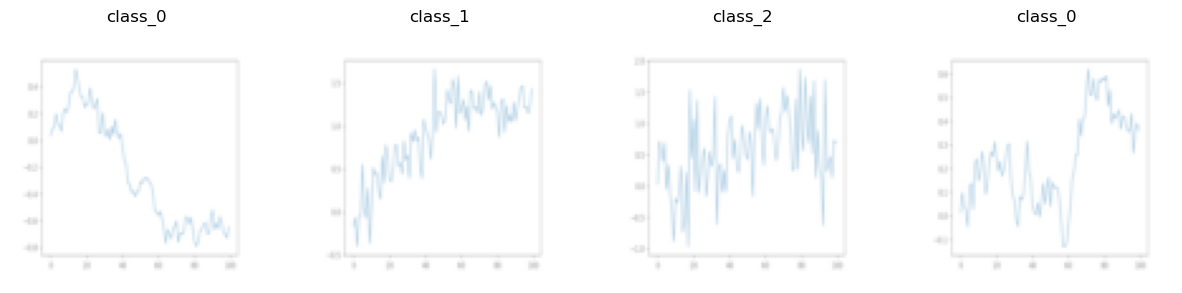

In [42]:
# Функция для отображения изображений и их меток
def image_shower(images, labels, class_names):
    num_images = len(images)
    rows = int(np.ceil(num_images / 4))
    fig, axs = plt.subplots(rows, 4, figsize=(15, 5 * rows))
    for i in range(rows):
        for j in range(4):
            idx = i * 4 + j
            if idx < num_images:
                img = images[idx] / 2 + 0.5
                np_img = img.numpy()
                if rows == 1:
                    axs[j].imshow(np.transpose(np_img, (1, 2, 0)))
                    axs[j].set_title(class_names[labels[idx]])
                    axs[j].axis('off')
                else:
                    axs[i, j].imshow(np.transpose(np_img, (1, 2, 0)))
                    axs[i, j].set_title(class_names[labels[idx]])
                    axs[i, j].axis('off')
    plt.show()

# Визуализация изображений и их меток
images, labels = next(iter(train_loader))
image_shower(images, labels, class_names)

In [43]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [44]:
model = torchvision.models.resnet18(pretrained=True)

C:\Anaconda\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Anaconda\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [45]:
# Create an instance of the neural network
num_classes = len(class_names)
model.fc = nn.Linear(model.fc.in_features, num_classes)
model = model.to(device)


In [21]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.1)
num_epochs = 4

In [22]:
train_losses = []
test_losses = []

train_accuracies = []
test_accuracies = []


for epoch in range(num_epochs):
    model.train()  
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)

        
        optimizer.zero_grad()

       
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        
        loss.backward()
        optimizer.step()

        
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()
        
        if i % 100 == 0:
            print(f"Epoch {epoch + 1}, Iteration {i + 1}, Loss: {loss.item()}")

    train_loss = running_loss / len(train_loader)
    train_accuracy = 100 * correct_train / total_train
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    print(f"Epoch {epoch + 1}, Training Loss: {train_loss}, Training Accuracy: {train_accuracy}%")

    model.eval()  
    correct_test = 0
    total_test = 0
    with torch.no_grad():
        for data in test_loader:
            images, labels = data[0].to(device), data[1].to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total_test += labels.size(0)
            correct_test += (predicted == labels).sum().item()

        test_loss = criterion(outputs, labels).item()
        test_accuracy = 100 * correct_test / total_test
        test_losses.append(test_loss)
        test_accuracies.append(test_accuracy)

        print(f"Epoch {epoch + 1}, Test Loss: {test_loss}, Test Accuracy: {test_accuracy}%")

print("Training finished!")

Epoch 1, Iteration 1, Loss: 0.0054722316563129425
Epoch 1, Iteration 101, Loss: 0.017600441351532936
Epoch 1, Iteration 201, Loss: 0.3588111400604248
Epoch 1, Iteration 301, Loss: 0.08534206449985504
Epoch 1, Iteration 401, Loss: 0.021532267332077026
Epoch 1, Iteration 501, Loss: 0.0032579428516328335
Epoch 1, Iteration 601, Loss: 0.007106107659637928
Epoch 1, Iteration 701, Loss: 0.0012416454264894128
Epoch 1, Iteration 801, Loss: 0.0017221311572939157
Epoch 1, Iteration 901, Loss: 0.009327631443738937
Epoch 1, Iteration 1001, Loss: 0.00012145405344199389
Epoch 1, Iteration 1101, Loss: 0.0005041795084252954
Epoch 1, Iteration 1201, Loss: 0.007089628372341394
Epoch 1, Training Loss: 0.1366545979953431, Training Accuracy: 95.92307692307692%
Epoch 1, Test Loss: 0.0026498031802475452, Test Accuracy: 94.9423076923077%
Epoch 2, Iteration 1, Loss: 0.0004960277583450079
Epoch 2, Iteration 101, Loss: 0.6839634776115417
Epoch 2, Iteration 201, Loss: 0.0023680655285716057
Epoch 2, Iteration 301,

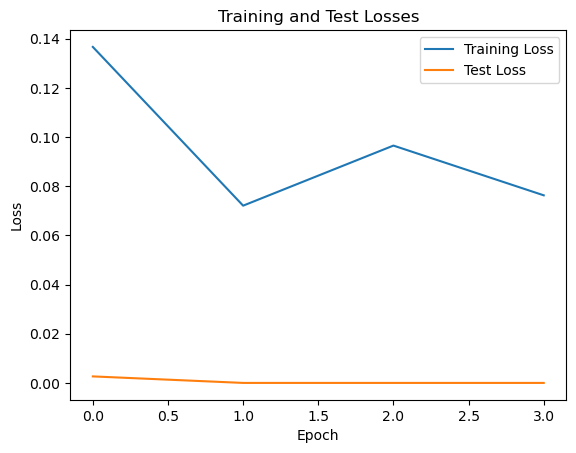

In [37]:
plt.plot(train_losses, label='Training Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Test Losses')
plt.show()

In [38]:
from sklearn.metrics import classification_report

model.eval()  
all_predictions = []
all_labels = []
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        all_predictions.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

class_report = classification_report(all_labels, all_predictions, target_names=class_names)
print("Classification Report:\n", class_report)

Classification Report:
               precision    recall  f1-score   support

     class_0       1.00      0.99      1.00      1300
     class_1       0.99      1.00      0.99      1300
     class_2       1.00      0.99      0.99      1300
     class_3       0.99      1.00      1.00      1300

    accuracy                           0.99      5200
   macro avg       0.99      0.99      0.99      5200
weighted avg       0.99      0.99      0.99      5200



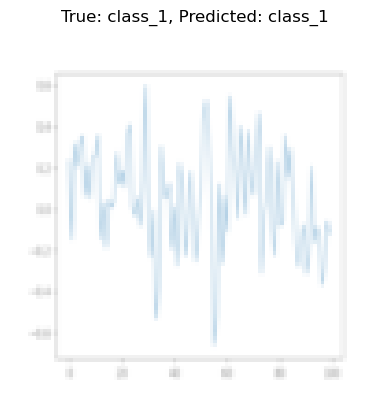

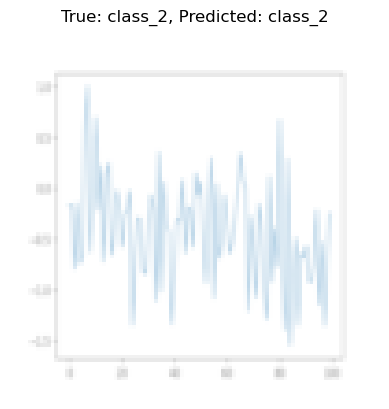

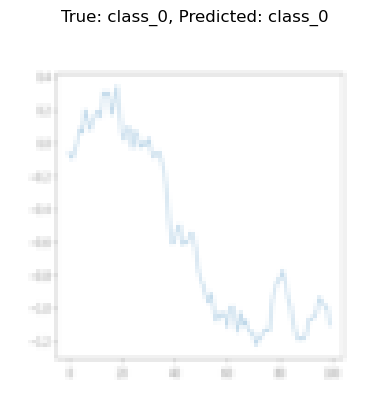

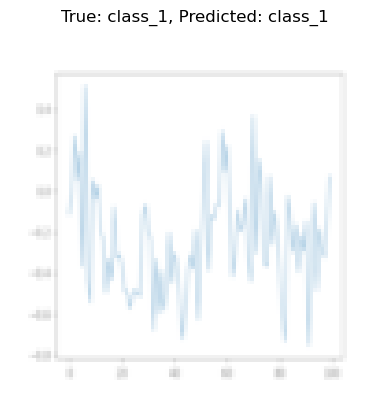

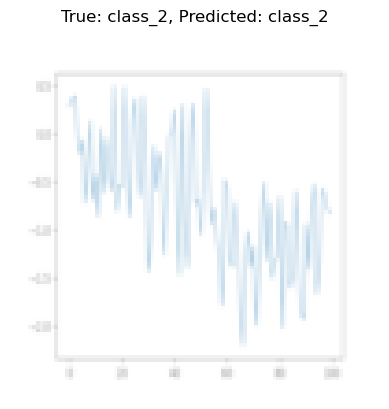

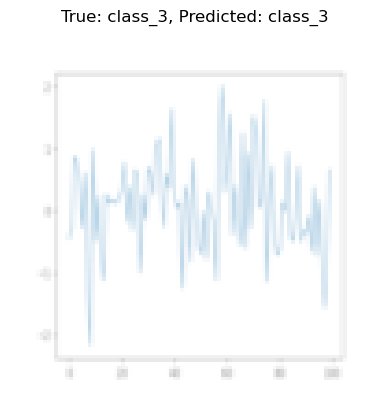

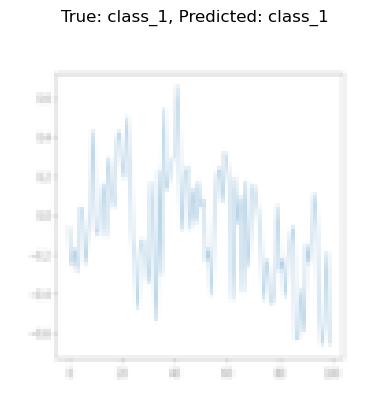

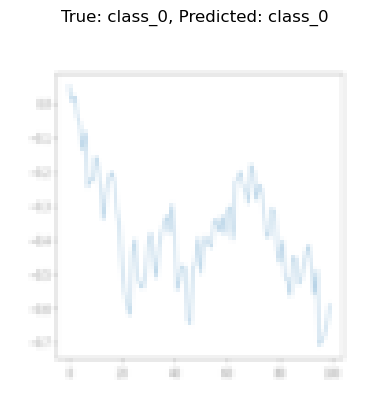

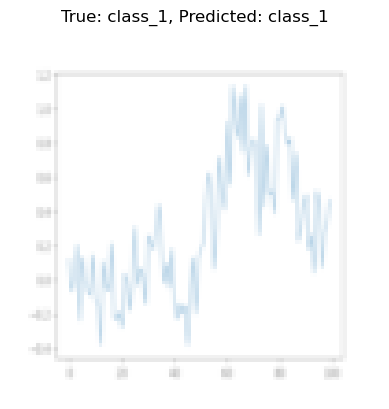

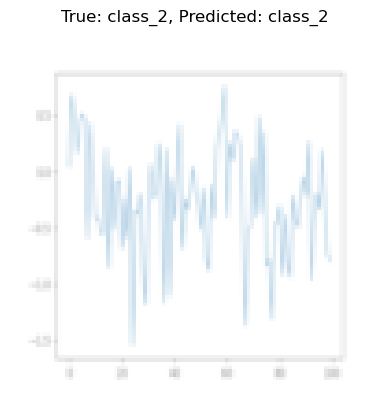

In [36]:
import random

model.eval()  
with torch.no_grad():
    examples_to_show = 10
    for i in range(examples_to_show):
        idx = random.randint(0, len(test_set) - 1) 
        image, true_label = test_set[idx]  
        image = image.unsqueeze(0).to(device)  
        true_label = torch.tensor(true_label).unsqueeze(0).to(device)  
        output = model(image)
        _, predicted_label = torch.max(output, 1)

        
        image = image.squeeze() / 2 + 0.5  
        np_image = image.permute(1, 2, 0).cpu().numpy()  
        plt.imshow(np_image)
        plt.title(f"True: {class_names[true_label.item()]}, Predicted: {class_names[predicted_label.item()]}")
        plt.axis('off')
        plt.show()
